In [71]:
#import
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

from torch.utils.tensorboard import SummaryWriter

pca_t=False
seed = 42
np.random.seed(seed)
random.seed(seed)

In [72]:
#import dataset
df = pd.read_csv('dataset-ml-25m/dataset.csv')

### Data Prepocessing

In [73]:
#split data and labels 
X = df.drop(['rating'], axis=1)
y = df['rating']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

#count the numebr of x_train x_val and x_test
print("Number of train set: ", X_train.shape[0])
print("Number of validation set: ", X_val.shape[0])
print("Numebr of test set: ", X_test.shape[0])

Number of train set:  9946
Number of validation set:  1106
Numebr of test set:  2764


In [74]:
if pca_t == True:
    pca = PCA(n_components=0.95)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)
else:
    print ("PCA is not applied")

PCA is not applied


### Linear Regressor
Con PCA:
- Mean Square Error: 0.00643
- R-square: 0.97096

Senza PCA:
- mse: 0.00544
- R2-square: 0.97543

In [75]:
log_name = f"linear_regression"
if pca_t == True:
    writer = SummaryWriter(f"results/tradML/pca/LinearRegression/{log_name}")
else:
    writer = SummaryWriter(f"results/tradML/no_pca/LinearRegression/{log_name}")

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)
y_pred = lin_regr.predict(X_test)

# Compute the RSS
mse = mean_squared_error(y_test, y_pred) 
print('Mean Square Error:', mse)
writer.add_scalar('Loss', mse)
writer.flush()

# Compute the R-square index
rsquare = r2_score(y_test, y_pred) 
print('R2-square:', rsquare)


Mean Square Error: 0.005445406919048585
R2-square: 0.9754341910082424


### Random Forest Regressor
Con PCA:
- Mean Squared Error:  0.03735
- R2 Score:  0.83150

Senza PCA:
- mse:  0.01255
- R2 Score:  0.94334

In [76]:
param_grid = {
                "n_estimators": [10, 15, 20, 25, 30],
                "criterion": ["squared_error", "friedman_mse"]
              }
rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)
best_hyper= grid_search.best_params_
print("Best hyper: ", best_hyper)


Best hyper:  {'criterion': 'friedman_mse', 'n_estimators': 30}


In [79]:
#display(grid_search.cv_results_)
## con pca
print(pca_t)
if pca_t == True:
    pd.DataFrame(grid_search.cv_results_).to_csv("tradML/cv_results/pca/RandomForestRegressor.csv")
else:
    pd.DataFrame(grid_search.cv_results_).to_csv("tradML/cv_results/no_pca/RandomForestRegressor.csv")


False


In [80]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_n_estimators', 'param_criterion', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
if pca_t == True:
    writer = SummaryWriter(f"results/tradML/pca/RandomForest/")
else:
    writer = SummaryWriter(f"results/tradML/no_pca/RandomForest/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    n_estimators = row['param_n_estimators']
    criterion = row['param_criterion']
    writer.add_hparams({"n_estimators": n_estimators, "criterion": criterion},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [81]:
rf = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
rf = rf.T
if pca_t == True:
    rf.to_csv('tradML/best_params/pca/random_forest.csv', index=False)
else:
    rf.to_csv('tradML/best_params/no_pca/random_forest.csv', index=False)

In [82]:
rf = RandomForestRegressor(criterion= 'friedman_mse', n_estimators=30)
rf= rf.fit(X_train,y_train)
y_pred= rf.predict(X_test)

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))


Mean Squared Error:  0.012738678622681958
R2 Score:  0.9425321283598643


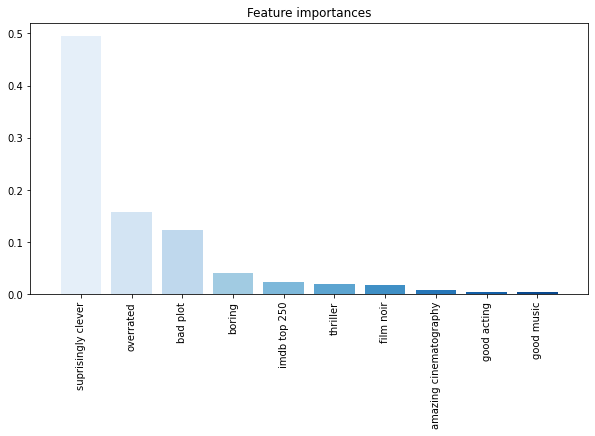

In [83]:
#features the first 10 most important with random forest with no PCA
if pca_t == False:
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X.columns

    # Crea il grafico
    my_palette = sns.color_palette("Blues", n_colors=10)
    plt.figure(figsize=(10,5))
    plt.title("Feature importances")
    plt.bar(range(10), importances[indices[0:10]], color=my_palette, align="center")
    plt.xticks(range(10), features[indices[0:10]], rotation=90)
    plt.xlim([-1, 10])
    plt.show()
else:
    print("PCA is applied, so no feature importance graph is shown")


### Ridge Regressor
Con PCA:
- Mean Squared Error:  0.00639
- R2 Score:  0.97113

Senza PCA:
- mse: 0.00532
- R2 Score:  0.97598

In [84]:
param_grid = {
                "alpha":[0.0001, 0.001, 0.1, 0.5, 1, 5, 10, 20]
              }
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best hyper: ", best_hyper)


Best hyper:  {'alpha': 5}


In [85]:
#display(grid_search.cv_results_)
if pca_t == True:
    writer = SummaryWriter(f"tradML/cv_results/pca/Ridge/")
else:
    writer = SummaryWriter(f"tradML/cv_results/no_pca/Ridge/")

In [86]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha','mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
if pca_t == True:
    writer = SummaryWriter(f"results/tradML/pca/Ridge")
else:
    writer = SummaryWriter(f"results/tradML/no_pca/Ridge")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    alpha = row['param_alpha']
    writer.add_hparams({"alpha": alpha},{"/hparam/mse": mse})
    writer.flush()
writer.close()

In [87]:
ridge = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
ridge = ridge.T
if pca_t == True:
    ridge.to_csv('tradML/best_params/pca/ridge.csv', index=False)
else:
    ridge.to_csv('tradML/best_params/no_pca/ridge.csv', index=False)

In [88]:
ridge = Ridge(**best_hyper)
ridge.fit(X_train, y_train)
y_pred= ridge.predict(X_test)

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))


Mean Squared Error:  0.005323110704793611
R2 Score:  0.9759859046789496


### KNN Regressor
Con PCA:
- Mean Squared Error:  0.04028
- R2 Score:  0.81828

Senza PCA:
- mse: 0.04050
- R2 Score:  0.81727

In [89]:
param_grid = {
                'n_neighbors': [7, 8, 9, 10, 15, 20],
                'weights': ['uniform', 'distance']
              }
knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best hyper: ", best_hyper)

Best hyper:  {'n_neighbors': 10, 'weights': 'distance'}


In [90]:
#display(grid_search.cv_results_)
if pca_t == True:
    pd.DataFrame(grid_search.cv_results_).to_csv("tradML/cv_results/pca/KNN.csv")
else:
    pd.DataFrame(grid_search.cv_results_).to_csv("tradML/cv_results/no_pca/KNN.csv")

In [91]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_n_neighbors', 'param_weights', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
if pca_t == True:
    writer = SummaryWriter(f"results/tradML/pca/KNN/")
else:
    writer = SummaryWriter(f"results/tradML/no_pca/KNN/")
writer = SummaryWriter(f"results/tradML/pca/KNN/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    n_neighbors = row['param_n_neighbors']
    weights = row['param_weights']
    writer.add_hparams({"n_neighbors": n_neighbors, "weights":weights},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [92]:
knn = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
knn = knn.T
if pca_t == True:
    knn.to_csv('tradML/best_params/pca/knn.csv', index=False)
else:
    knn.to_csv('tradML/best_params/no_pca/knn.csv', index=False)

In [93]:
knn = KNeighborsRegressor(**best_hyper)
knn.fit(X_train, y_train)
y_pred= knn.predict(X_test)

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

Mean Squared Error:  0.040503488522491256
R2 Score:  0.8172770231251678


### Lasso Regressor
Con PCA:
- Mean Squared Error:  0.00641
- R2 Score:  0.97106

Senza PCA:
- 0.00542
- R2 Score:  0.97553


In [94]:
param_grid = {
                'alpha':[1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
              }
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best hyper: ", best_hyper)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.527e+00, tolerance: 1.880e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.996e+00, tolerance: 1.910e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.742e+00, tolerance: 1.920e-01

Best hyper:  {'alpha': 1e-05}


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e+01, tolerance: 2.373e-01
  model = cd_fast.enet_coordinate_descent(


In [95]:
#display(grid_search.cv_results_)
if pca_t == True:
    pd.DataFrame(grid_search.cv_results_).to_csv("tradML/cv_results/pca/Lasso.csv")
else:
    pd.DataFrame(grid_search.cv_results_).to_csv("tradML/cv_results/no_pca/Lasso.csv")

In [96]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha','mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
if pca_t == True:
    writer = SummaryWriter(f"results/tradML/pca/Lasso/")
else:
    writer = SummaryWriter(f"results/tradML/no_pca/Lasso/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    alpha = row['param_alpha']
    writer.add_hparams({"alpha": alpha},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [97]:
lasso = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
lasso= lasso.T
if pca_t == True:
    lasso.to_csv('tradML/best_params/pca/lasso.csv', index=False)
else:
    lasso.to_csv('tradML/best_params/no_pca/lasso.csv', index=False)

In [98]:
lasso = Lasso(**best_hyper)
lasso.fit(X_train, y_train)
y_pred= lasso.predict(X_test)

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

Mean Squared Error:  0.005423553353396875
R2 Score:  0.9755327787772686


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e+01, tolerance: 2.373e-01
  model = cd_fast.enet_coordinate_descent(


In [99]:
if pca_t == False:
    #print null coefficients for lasso and name of features without pca
    lasso_coef = pd.DataFrame(lasso.coef_, index=X.columns, columns=['value'])
    lasso_coef = lasso_coef[lasso_coef['value'] == 0]
    print("Number of features that are zero: ", len(lasso_coef))

    lasso_coef = pd.DataFrame(lasso.coef_, index=X.columns, columns=['value'])
    lasso_coef = lasso_coef[lasso_coef['value'] == 0]
    X_zero_coef = X[lasso_coef.index]
    # corr between features set to 0 and y
    corr = X_zero_coef.corrwith(y)
    display(corr.head(10))

Number of features that are zero:  146


007           -0.097706
1920s          0.379278
3d            -0.153728
aardman        0.060788
afterlife     -0.079177
alcoholism     0.206545
almodovar      0.083976
amnesia        0.062696
animation      0.024383
arms dealer   -0.073337
dtype: float64

### SVR
Con PCA:
- Mean Squared Error: 0.00645
- R2 Score: 0.97086

Senza PCA:
- mse: 0.00544
- R2 Score: 0.97543

In [100]:
param_grid = {
                'kernel': ['linear', 'poly', 'rbf'],
                'epsilon': [0.001, 0.01, 0.1, 1]
              }
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper = grid_search.best_params_
print("Best hyper ", best_hyper)

Best hyper  {'epsilon': 0.001, 'kernel': 'rbf'}


In [101]:
#display(grid_search.cv_results_)
if pca_t == True:
    pd.DataFrame(grid_search.cv_results_).to_csv("tradML/cv_results/pca/SVR.csv")
else:
    pd.DataFrame(grid_search.cv_results_).to_csv("tradML/cv_results/no_pca/SVR.csv")

In [102]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_kernel','param_epsilon' ,'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1


#save mse to tensorboard
if pca_t == True:
    writer = SummaryWriter(f"results/tradML/pca/SVR/")
else:
    writer = SummaryWriter(f"results/tradML/no_pca/SVR/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    kernel = row['param_kernel']
    epsilon = row['param_epsilon']
    writer.add_hparams({"kernel": kernel, "epsilon":epsilon},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [103]:
svr = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
svr = svr.T
if pca_t == True:   
    svr.to_csv('tradML/best_params/pca/svr.csv', index=False)
else:
    svr.to_csv('tradML/best_params/no_pca/svr.csv', index=False)

In [104]:
svr = SVR(**best_hyper)
svr.fit(X_train, y_train)
y_pred= svr.predict(X_test)

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

Mean Squared Error:  0.005214488613478723
R2 Score:  0.9764759304175574
